## 决策树
决策树是多功能的机器学习算法，可以执行分类和回归任务，甚至可以执行多输出任务。它们是功能强大的算法，能够拟合复杂的数据集。例如，在加州房屋数据集中训练了DecisionTreeRegressor模型，使其完全拟合（实际上是过拟合）。

决策树也是随机森林的基本组成部分，它们是当今最强大的机器学习算法之一。

将讨论如何使用决策树进行训练，可视化和做出预测开始。然后，将了解Scikit-Learn使用的CART训练算法，并将探索如何对树进行正则化并将其用于回归任务。最后，将讨论决策树的一些局限性。

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [4]:
# 可视化决策树，用export_graphviz() 函数输出一个图形定义文件
from sklearn.tree import export_graphviz

export_graphviz(tree_clf,
                out_file="./images/decision_tree/iris_tree.dot",
                feature_names=["petal length (cm)", "petal width (cm)"],
                class_names=iris.target_names,
                rounded=True,
                filled=True)


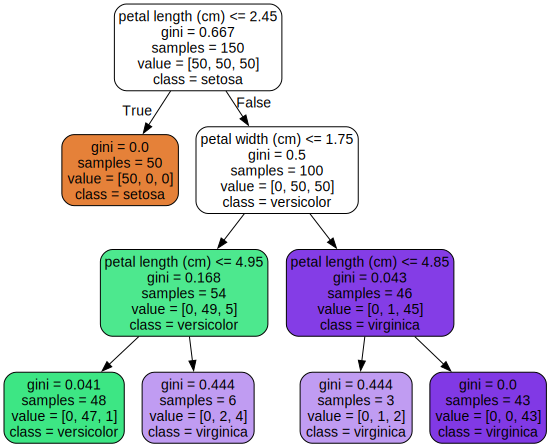

In [5]:
# 使用graphviz.Source.from_file() 加载并显示该文件
from graphviz import Source

Source.from_file("./images/decision_tree/iris_tree.dot")

找到一朵鸢尾花，并希望根据它的花瓣对其进行分类。你从根节点开始（深度0，顶部）​：该节点询问花的花瓣长度是否小于等于2.45cm。如果是，则向下移动到根的左子节点（深度1，左）。在这种情况下，它是一个叶节点（即它没有任何子节点），因此它不会提出任何问题：只需查看该节点的预测类，然后决策树就可以预测你的花朵是Setosa鸢尾花(class=setosa)。

假设找到另一朵花，这次花瓣的长度大于2.45 cm。再次从根开始，但现在向下移动到它的右子节点（深度1，右）。这不是叶节点，是拆分节点，所以又问了一个问题：花瓣宽度是否小于等于1.75cm？如果是，那么花很可能是Versicolor鸢尾花（深度2，左）。如果不是，则可能是Virginica鸢尾花（深度2，右)

决策树的特质之一就是它们几乎不需要数据准备。实际上，它们根本不需要特征缩放或居中。

b节点的samples属性统计它应用的训练实例数量。例如，有100个训练实例的花瓣长度大于2.45cm（深度1，右），其中54个花瓣宽度小于1.75cm（深度2，左）。

节点的value属性说明了该节点上每个类的训练实例数量：例如，右下节点应用在0个Setosa鸢尾花、1个Versicolor鸢尾花和45个Virginica鸢尾花实例上。

最后，节点的gini属性衡量其基尼杂质：如果应用的所有训练实例都属于同一个类，那么节点就是“纯”的(gini=0)。例如，深度1左侧节点仅应用于Setosa鸢尾花训练实例，因此它是纯的并且其基尼杂质为0。以下公式说明了第i个节点的基尼杂质Gi的计算方式。例如，深度2左侧节点，基尼杂质等于
1-(0/54)^2-(49/54)^2-(5/54)^2≈0.168。

$$
G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2
$$

在此公式中：

- $ G_i $ 是第 i 个节点的基尼杂质。
- $ p_{i,k} $ 是第  i  个节点中训练实例之间的第 k 类实例的比率。



决策树的决策边界。加粗垂直实线表示根节点（深度0）的决策边界：花瓣长度=2.45cm。因为左侧区域是纯的（只有Setosa鸢尾花），所以它不可再分。

但是右侧区域是不纯的，所以深度1右侧的节点在花瓣宽度=1.75cm处（虚线所示）再次分裂。

因为这里最大深度max_depth设置为2，所以决策树在此停止。但是如果将max_depth设置为3，那么两个深度为2的节点将各自再产生一条决策边界

![决策树的决策边界](./images/decision_tree/p1.png)

### 估计类概率
决策树同样可以估算某个实例属于特定类k的概率：首先，跟随决策树找到该实例的叶节点，然后返回该节点中类k的训练实例占比。

例如，假设发现一朵花，其花瓣长5cm，宽1.5cm。相应的叶节点为深度2左侧节点，因此决策树输出如下概率：Setosa鸢尾花，0%(0/54)；Versicolor鸢尾花，90.7%(49/54)；Virginica鸢尾花，9.3%(5/54)。

要求它预测类，那么它会输出Versicolor鸢尾花（类1），因为它的概率最大

In [6]:
tree_clf.predict_proba([[5,1.5]]).round(3)

tree_clf.predict([[5, 1.5]])

array([2])

In [7]:
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
tree_clf_deeper.predict_proba([[6,1.5]]).round(3)

array([[0.   , 0.333, 0.667]])

### CART训练算法
Scikit-Learn使用分类和回归树(Classification and Regression Tree，CART)算法来训练决策树（也称为“增长树”）。

该算法的工作原理是，首先使用单个特征k和阈值tk（例如，“花瓣长度≤2.45cm”）将训练集分为两个子集。

如何选择k和tk？它搜索产生最纯子集的一对(k，tk)，按其大小加权。以下公式给出了算法试图最小化的代价函数。

$$
J(k, t_k) = \frac{m_{\text{左}}}{m} G_{\text{左}} + \frac{m_{\text{右}}}{m} G_{\text{右}}
$$

其中：

- $ G_{\text{左/右}} $：测量左/右子集的不纯度, 可以用基尼指数衡量
- $ m_{\text{左/右}} $：测量左/右子集的实例数

一旦CART算法成功地将训练集分为两部分，它就会使用相同的逻辑将子集进行拆分，然后再拆分子子集，以此类推。一旦达到最大深度（由max_depth超参数定义），或者找不到可减少不纯度的分割，它将停止递归。其他一些超参数可以控制其他一些停止条件：min_samples_split、min_samples_leaf、min_weight_fraction_leaf和max_leaf_nodes。

bCART是一种贪心算法：从顶层开始搜索最优拆分，然后每层重复这个过程。几层拆分之后，它并不会检视这个拆分的不纯度是否为可能的最小值。贪心算法通常会产生一个相当不错的解，但是不能保证是最优解。

寻找全局最优的树需要访问所有的可能性，需要O(exp(m))时间，即使小训练集也需要花费很多时间，所以训练决策树满足于“不错”的解决方案。

### 计算复杂度
进行预测需要从根到叶遍历决策树。决策树通常是近似平衡的，因此遍历决策树需要经过大约 O($ log_2(m)$)  个节点，其中 $ log_2(m) $ 是 m 的二进制对数，等于 log(m)/log(2)。由于每个节点仅需检查一个特征值，因此总体预测复杂度为 O($log_2(m)$)，与特征数量无关。因此，即使处理大训练集，预测也非常快。

训练算法比较每个节点上所有样本上的所有特征值（如果设置了 `max_features`，则更少）。比较每个节点上所有样本的所有特征会导致训练复杂度为 $ O(n \times m \log_2(m)) $。


### 基尼杂质或熵

默认情况下，DecisionTreeClassifier类使用基尼杂质来度量，但是，可以将超参数criterion设置为"entropy"来选择信息熵作为杂质的测量方式。

熵是衡量一个节点中数据混杂程度的指标。如果一个节点中的样本全部属于同一类，那么熵为 0，表示纯度最高；如果样本被多个类均匀分布，则熵较高，表示更混杂。

例如，某个节点中共有 54 个样本，其中 49 个是正类，5 个是负类，则该节点的熵为：

$$
H_i = -\frac{49}{54} \log_2\left(\frac{49}{54}\right) - \frac{5}{54} \log_2\left(\frac{5}{54}\right) \approx 0.445
$$

这个值表示该节点的样本并不是完全纯净的，存在一定的混杂程度。


熵越大，表示一个节点中的样本分布越均匀、越混杂。比如下面两个节点的对比：

- **节点 A** 中有 50 个样本，其中 49 个是正类、1 个是负类：

  $$
  H_A = -\frac{49}{50} \log_2\left(\frac{49}{50}\right) - \frac{1}{50} \log_2\left(\frac{1}{50}\right) \approx 0.081
  $$

  熵很小，说明这个节点很“纯”。

- **节点 B** 中有 50 个样本，25 个是正类，25 个是负类：

  $$
  H_B = -\frac{25}{50} \log_2\left(\frac{25}{50}\right) - \frac{25}{50} \log_2\left(\frac{25}{50}\right) = -0.5 \log_2(0.5) - 0.5 \log_2(0.5) = 1
  $$

  熵为 1，是两类最均匀的情况，表示完全混乱。

因此，在决策树中我们更倾向于选择那些**可以把数据划分为低熵子集的特征**，以提升纯度。

公式：
$$
H_i = -\sum_{\substack{k=1 \\ p_{i,k} \ne 0}}^{n} p_{i,k} \log_2(p_{i,k})
$$



那么应该使用基尼杂质还是信息熵呢？其实，大多数情况下，它们并没有什么大的不同，产生的树都很相似。基尼杂质的计算速度略微快一些，所以它是个不错的默认选择。它们的不同在于，基尼杂质倾向于从树枝中分裂出最常见的类，而信息熵则倾向于生成更平衡的树

### 正则化超参数

决策树极少对训练数据做出假设（比如线性模型就正好相反，它显然假设数据是线性的）。如果不加以限制，树的结构将跟随训练集变化，严密拟合，并且很可能过拟合。

这种模型通常被称为非参数模型，这不是说它不包含任何参数（事实上它通常有很多参数），而是指在训练之前没有确定参数的数量，导致模型结构自由而紧密地贴近数据。

相应的参数模型，比如线性模型，则有预先设定好的一部分参数，因此其自由度受限，从而降低了过拟合的风险（但是增加了欠拟合的风险）。

为避免过拟合，需要在训练过程中降低决策树的自由度（正则化）。正则化超参数的选择取决于你所使用的模型，但是通常来说，至少可以限制决策树的最大深度。在Scikit-Learn中，这由超参数max_depth控制，默认值为None，意味着无限制。减小max_depth可使模型正则化，从而降低过拟合的风险。

DecisionTreeClassifier类有一些其他参数类似地限制决策树的形状：

- max_features: 为在每个节点处进行拆分而评估的最大特征数
- max_leaf_nodes: 最大叶节点数
- min_samples_split: 一个节点在拆分之前必须拥有的最小样本数
- min_samples_leaf: 必须创建叶节点的最小样本数
- min_weight_fraction_leaf: 与min_samples_leaf相同效果，但表示为加权实例总数的一小部分 （这个参数主要用于加权决策树，也就是说，每个样本不仅仅是“1票”，而是可能有不同的权重（weight））

增加min_*,或者减少max_*超参数将使模型正则化

In [8]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

In [9]:
# 非正则化的模型明显过拟合，正则化后的树泛化得更好
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2, random_state=43)
tree_clf1.score(X_moons_test, y_moons_test)
tree_clf2.score(X_moons_test, y_moons_test)

0.92

![非正则化树和正则化树的决策边界](./images/decision_tree/p2.png)

### 决策树回归

In [34]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42, min_samples_leaf=5)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, min_samples_leaf=5, random_state=42)

In [35]:
export_graphviz(tree_reg,
                out_file="./images/decision_tree/tree_reg_1.dot",
                feature_names=["x1"],
                rounded=True,
                filled=True)

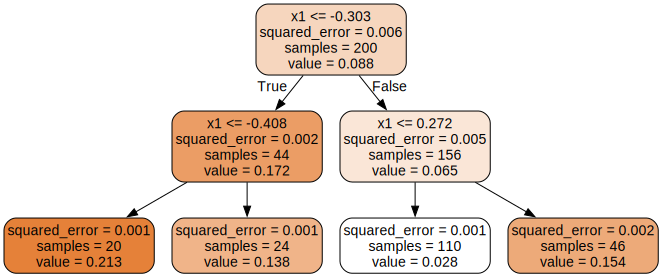

In [36]:
Source.from_file("./images/decision_tree/tree_reg_1.dot")

这棵树看起来与之前构建的分类树非常相似。

主要区别在于它不是预测每个节点中的类，而是预测一个值。例如，假设你要对x1=0.2的新实例进行预测。根节点询问是否x1≤-0.303。既然不是，则算法转到右子节点，它询问是否x1≤0.272。既然是，算法继续转到左子节点。这是一个叶节点，它预测value=0.028。

此预测是与此叶节点关联的110个训练实例的平均目标值，它在这29个实例上产生等于0.028的均方误差。

In [37]:
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42, min_samples_leaf=5)
tree_reg2.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=3, min_samples_leaf=5, random_state=42)

In [38]:
tree_reg.tree_.threshold
tree_reg2.tree_.threshold

array([-0.30265072, -0.40830374, -0.45416115, -2.        , -2.        ,
       -0.37022041, -2.        , -2.        ,  0.27175756, -0.21270403,
       -2.        , -2.        ,  0.40399227, -2.        , -2.        ])

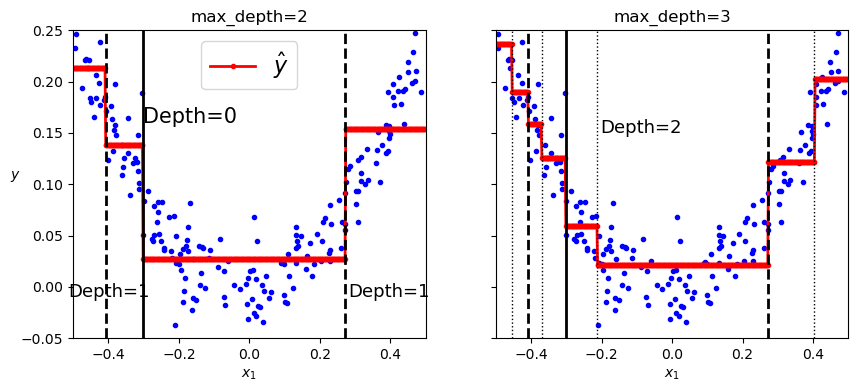

In [41]:
# 每个区域的预测值永远等于该区域内实例的目标平均值。算法拆分每个区域的方法，使最多的训练实例尽可能接近这个预测值。
import matplotlib.pyplot as plt

def plot_regression_predictions(tree_reg, X, y, axes=[-0.5, 0.5, -0.05, 0.25]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$")
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg, X_quad, y_quad)

th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]  # 阈值的编号 按照深度优先搜索（先序遍历）的遍历顺序 （根左右）
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)

plt.text(th0, 0.16, "Depth=0", fontsize=15)
plt.text(th1a + 0.01, -0.01, "Depth=1", horizontalalignment="center", fontsize=13)
plt.text(th1b + 0.01, -0.01, "Depth=1", fontsize=13)
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center", fontsize=16)
plt.title("max_depth=2")

plt.sca(axes[1])
th2s = tree_reg2.tree_.threshold[[2, 5, 9, 12]]   # 在深度2 的阈值全部画一下
plot_regression_predictions(tree_reg2, X_quad, y_quad)
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
for split in th2s:
    plt.plot([split, split], [-0.05, 0.25], "k:", linewidth=1)
plt.text(th2s[2] + 0.01, 0.15, "Depth=2", fontsize=13)
plt.title("max_depth=3")

plt.show()


CART算法的工作原理如前所述，只是它不再尝试以最小化杂质的方式拆分训练集，而是尝试以最小化 MSE 的方式拆分训练集。下面公式 给出了算法试图最小化的代价函数。

**公式：CART 回归代价函数**

$$
J(k, t_k) = \frac{m_{\text{左}}}{m} \text{MSE}_{\text{左}} + \frac{m_{\text{右}}}{m} \text{MSE}_{\text{右}}
$$

其中

$$
\text{MSE}_{\text{node}} = \frac{\sum_{i \in \text{node}} (\hat{y}_{\text{node}} - y^{(i)})^2}{m_{\text{node}}}
$$

$$
\hat{y}_{\text{node}} = \frac{\sum_{i \in \text{node}} y^{(i)}}{m_{\text{node}}}
$$


就像分类任务一样，决策树在处理回归任务时容易过拟合。

如果不进行任何正则化（如使用默认的超参数）, 很容易过拟合，得到下面代码生成的预测，只需设置min_samples_leaf=10可以得到一个更合理的模型

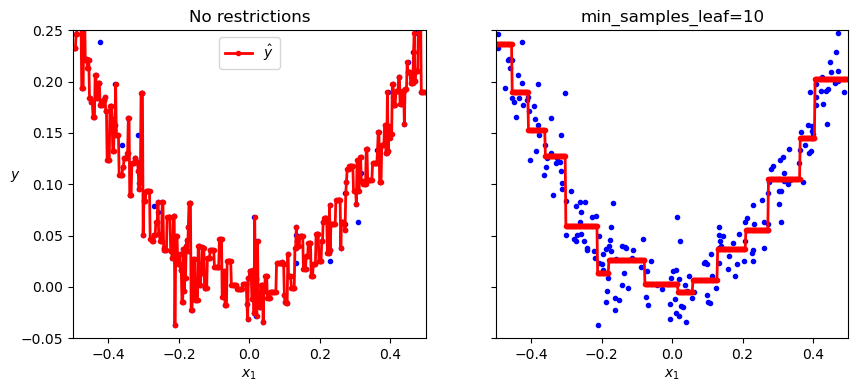

In [57]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X_quad, y_quad)
tree_reg2.fit(X_quad, y_quad)

x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center")
plt.title("No restrictions")

plt.sca(axes[1])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.title(f"min_samples_leaf={tree_reg2.min_samples_leaf}")

plt.show()

In [72]:
# 随堂练习：验证不加限制的决策树，是不是在叶子节点，样本数量拆分得只剩一个

(399,)

### 决策树对轴方向的敏感性

决策树相对容易理解和解释、易于使用、用途广泛且功能强大。但是，它们确实有一些限制。首先，决策树喜欢正交决策边界（所有拆分都垂直于轴），这使得它们对数据的方向很敏感。例如，下图显示了一个简单的线性可分数据集：在左侧，决策树可以轻松地将其拆分，而在右侧，将数据集旋转45°后，决策边界看起来不必要地复杂。虽然两棵决策树都完美地拟合训练集，但右边的模型很可能无法很好地泛化。

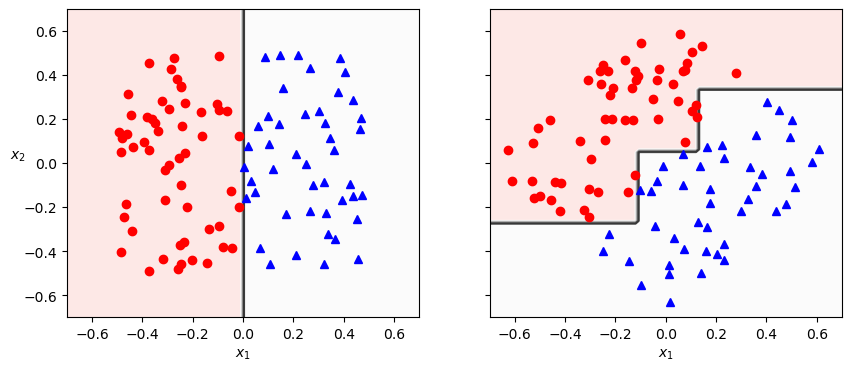

In [87]:
def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)  # 根据预测值画颜色渐变，自动形成边界
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)  # 等高线图 只画边界线，边界会更新
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")


    # 画数据点
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="")

    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

np.random.seed(6)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

angle = np.pi / 4  # 45 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.ylabel("")

plt.show()


限制此问题的一种方法是缩放数据，然后应用主成分分析转换(PCA)。

将在无监督学习里的降维介绍PCA，但现在只需要知道它以降低特征之间相关性的方式旋转数据，这通常（并非总是）使树的处理变得更容易。

创建一个小型流水线来缩放数据并使用PCA旋转它，然后在该数据上训练DecisionTreeClassifier。旋转使得仅使用一个特征z1就可以很好地拟合数据集，它是原始花瓣长度和宽度的线性函数。

In [88]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

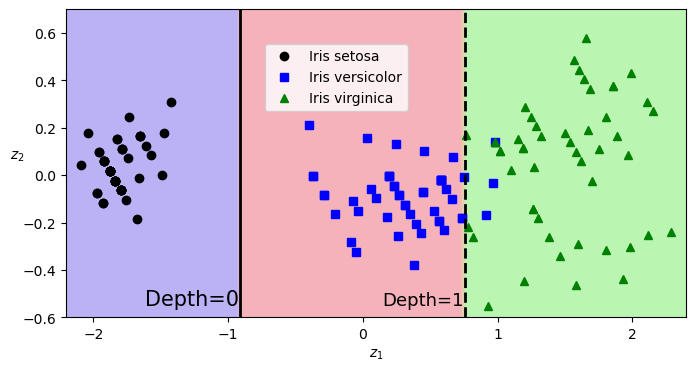

In [90]:
plt.figure(figsize=(8, 4))

axes = [-2.2, 2.4, -0.6, 0.7]
z0s, z1s = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                       np.linspace(axes[2], axes[3], 100))
X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=plt.cm.brg)
for idx, (name, style) in enumerate(zip(iris.target_names, ("ko", "bs", "g^"))):
    plt.plot(X_iris_rotated[:, 0][y_iris == idx],
             X_iris_rotated[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]
plt.plot([th1, th1], axes[2:], "k-", linewidth=2)
plt.plot([th2, th2], axes[2:], "k--", linewidth=2)
plt.text(th1 - 0.01, axes[2] + 0.05, "Depth=0",
         horizontalalignment="right", fontsize=15)
plt.text(th2 - 0.01, axes[2] + 0.05, "Depth=1",
         horizontalalignment="right", fontsize=13)
plt.axis(axes)
plt.legend(loc=(0.32, 0.67))

plt.show()

### 决策树有高方差

决策树还有个主要问题是具有相当高的方差：超参数或数据的微小变化可能会产生非常不同的模型。

事实上，由于Scikit-Learn使用的CART训练算法是随机的——它随机选择一组特征在每个节点上进行评估——即使在完全相同的数据上重新训练相同的决策树也可能会产生非常不同的模型

通过对许多树的预测进行平均，可以显著减少方差。这样的树集合称为随机森林

In [91]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=40)

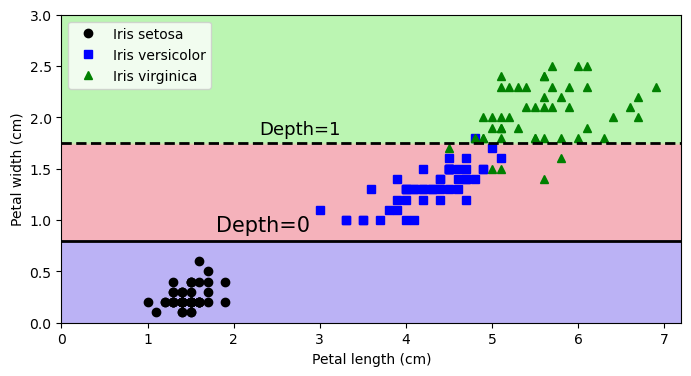

In [97]:
plt.figure(figsize=(8, 4))
lengths, widths = np.meshgrid(np.linspace(0, 7.5, 100), np.linspace(0, 3, 100))

X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf_tweaked.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=plt.cm.brg)

for idx, (name, style) in enumerate(zip(iris.target_names, ("ko", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

th0, th1 = tree_clf_tweaked.tree_.threshold[[0, 2]]
plt.plot([0, 7.2], [th0, th0], "k-", linewidth=2)
plt.plot([0, 7.2], [th1, th1], "k--", linewidth=2)
plt.text(1.8, th0 + 0.05, "Depth=0", verticalalignment="bottom", fontsize=15)
plt.text(2.3, th1 + 0.05, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.axis([0, 7.2, 0, 3])
plt.legend()
plt.show()